**Оглавление**

>[Загрузка библиотек](#scrollTo=8fGyjd145I0t)

>[Загрузка данных](#scrollTo=mr3jdbSW5SkR)

>[Pre-processing](#scrollTo=zakCy45OcNxI)

>[Модели](#scrollTo=WzCnTFJIdwVf)

>[Предсказание на test выборке](#scrollTo=j-c4PRFtK2ol)



### Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import tensorflow as tf 
import tensorflow.keras as keras
from keras.layers import Dense, LSTM, Embedding, Dropout

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

In [ ]:
!pip install sentence_transformers

### Загрузка данных

In [ ]:
sns.set_palette("icefire", 15)

In [ ]:
train = pd.read_csv("/content/train_tin.csv", encoding= "CP1251")
test = pd.read_csv("/content/test_tin.csv", encoding= "CP1251")

In [ ]:
test.head(5)

,text,isPositive
0,Добрый день! Я являюсь клиентом Тинькофф банк ...,NaN
1,Хочу выразить огромную благодарность банку Тин...,NaN
2,Выражаю благодарность К-ву Александру В. за ст...,NaN
3,В январе 2019 года оформила потребительский кр...,NaN
4,Добрый день. Хочу поблагодарить банк Тинькофф ...,NaN


In [ ]:
train.head(5)

,text,isPositive
0,"27.09.19 через сайт в разделе ""Рефинансировани...",0
1,Добрый день! Неоднократно поступают звонки по ...,0
2,В первый раз решила воспользоваться кредитной ...,0
3,На самом дело уже накипело из-за участившегося...,0
4,Если вы дорожите своими нервами - ни при каких...,0


In [ ]:
train.shape

(3950, 2)

Посмотрим сколько у нас положительных и отрицательных отзывов:

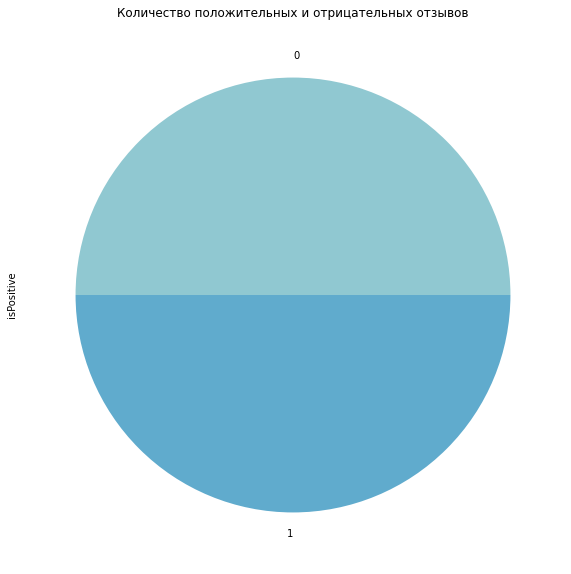

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Количество положительных и отрицательных отзывов")
train["isPositive"].value_counts().plot.pie()
plt.show()

Данные у нас сбалансированные относительно целевой переменной.

### Pre-processing

Для улучшения качества модели используются методы очситки и обработки текста.

In [ ]:
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])
spec_chars = string.punctuation 

Необходимо очистить текст от пунктуационных символов и от "стоп-слов".

In [16]:
train_2 = train.copy()
test_2 = test.copy()
train_2.text = train_2.text.apply(lambda x : remove_chars_from_text(x,spec_chars))
test_2.text = test_2.text.apply(lambda x : remove_chars_from_text(x,spec_chars))

Уберем перенос строки

In [17]:
train_2.text = train_2.text.apply(lambda x : re.sub(r'\n'," ",x))
test_2.text = test_2.text.apply(lambda x : re.sub(r'\n'," ",x))

Убираем заглавные буквы

In [18]:
train_2.text  = train_2.text.apply(lambda x : x.lower())
test_2.text  = test_2.text.apply(lambda x : x.lower())

In [19]:
train_2.text.head()

0    270919 через сайт в разделе рефинансирование с...
1    добрый день неоднократно поступают звонки по д...
2    в первый раз решила воспользоваться кредитной ...
3    на самом дело уже накипело изза участившегося ...
4    если вы дорожите своими нервами  ни при каких ...
Name: text, dtype: object

Разделяем текст на токены

In [22]:
train_2.text.head()

0    270919 сайт разделе рефинансирование сторонних...
1    добрый день неоднократно поступают звонки долж...
2    первый решила воспользоваться кредитной картой...
3    самом дело накипело изза участившегося намахал...
4    дорожите своими нервами каких обстоятельствах ...
Name: text, dtype: object

Приводит слова к инфинитиву и очищаем текст от "стоп-слов"

In [21]:
STOPWORDS = set(stop_words)
test_2.text  = test_2.text.apply(lambda x : ' '.join(word for word in x.split() if word not in STOPWORDS))
train_2.text  = train_2.text.apply(lambda x : ' '.join(word for word in x.split() if word not in STOPWORDS))

### Модели

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_2.text, train_2["isPositive"], test_size=0.3, random_state=0)

In [26]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= 50000, filters= spec_chars, lower=True)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index

In [27]:
#train data
vectors = tokenizer.texts_to_sequences(X_train.values)
vectors = tf.keras.utils.pad_sequences(vectors, maxlen= 300 )

In [28]:
#validation data 
test_Emb = tokenizer.texts_to_sequences(X_test.values)
test_Emb = tf.keras.utils.pad_sequences(test_Emb, maxlen= 300)

In [46]:
test_final = tokenizer.texts_to_sequences(test_2.text.values)
test_final = tf.keras.utils.pad_sequences(test_final, maxlen= 300)

In [29]:
y_train_2 = pd.get_dummies(y_train).values
y_train_2

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

Baseline Model SVM

In [31]:
mdl = LinearSVC(random_state=0, max_iter=1000).fit(vectors, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [61]:
y_pred = mdl.predict(test_Emb)
print("Accuracy : {}".format(accuracy_score(y_test,y_pred).round(3)))

Accuracy : 0.576


Random Forest

In [33]:
forest = RandomForestClassifier(max_depth=7,criterion = "entropy",
                                n_estimators= 500, random_state=0)
forest.fit(vectors, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=500,
                       random_state=0)

In [60]:
y_pred_forest = forest.predict(test_Emb)
print("Accuracy : {}".format(accuracy_score(y_test,y_pred_forest).round(3)))

Accuracy : 0.683


Попробуем улучшить качество модели с помощью нейронных сетей.

In [37]:
tf.random.set_seed(0)
Init = keras.initializers.RandomNormal(seed=0)
model = tf.keras.Sequential([
    Embedding(50000, 64, input_length= vectors.shape[1]),
    LSTM(64,dropout=0.2,),
    Dense(y_train_2.shape[1],activation='softmax')
])

In [38]:
model.summary()
loss = tf.keras.losses.BinaryCrossentropy() 
model.compile(loss=loss, optimizer="adam", metrics=["accuracy"]) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 64)           3200000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,233,154
Trainable params: 3,233,154
Non-trainable params: 0
_________________________________________________________________


In [39]:
hist = model.fit(vectors, y_train_2, epochs=5, validation_split=.3)

Epoch 1/5
61/61 [==============================] - 18s 237ms/step - loss: 0.6197 - accuracy: 0.6672 - val_loss: 0.3742 - val_accuracy: 0.8880
Epoch 2/5
61/61 [==============================] - 14s 228ms/step - loss: 0.2112 - accuracy: 0.9344 - val_loss: 0.3178 - val_accuracy: 0.8759
Epoch 3/5
61/61 [==============================] - 14s 237ms/step - loss: 0.0595 - accuracy: 0.9850 - val_loss: 0.1949 - val_accuracy: 0.9313
Epoch 4/5
61/61 [==============================] - 15s 247ms/step - loss: 0.0117 - accuracy: 0.9984 - val_loss: 0.2115 - val_accuracy: 0.9325
Epoch 5/5
61/61 [==============================] - 14s 228ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2127 - val_accuracy: 0.9325


In [43]:
y_pred_nn = model.predict(test_Emb)
pY = pd.DataFrame(np.argmax(y_pred_nn, axis = 1), columns=['y'])

38/38 [==============================] - 2s 41ms/step


In [62]:
print("Accuracy : {}".format(accuracy_score(y_test,pY.y).round(3)))

Accuracy : 0.93


### Предсказание

Лучше всех предсказывала модель получилась с применением нейронных сетей, поэтому прогнозирование тестовой выборки будет проводится на данной модели.

In [52]:
y_pred_final = model.predict(test_final)
Y = np.argmax(y_pred_final, axis = 1)

32/32 [==============================] - 1s 40ms/step


In [53]:
test["isPositive"] = Y

In [54]:
test.head()

,text,isPositive
0,Добрый день! Я являюсь клиентом Тинькофф банк ...,0
1,Хочу выразить огромную благодарность банку Тин...,1
2,Выражаю благодарность К-ву Александру В. за ст...,1
3,В январе 2019 года оформила потребительский кр...,0
4,Добрый день. Хочу поблагодарить банк Тинькофф ...,1


In [ ]:
test.to_csv("/content/test_final.csv")